<h1><img src='https://sprtsiq.com/img/logo/SprtsIQ_Logo.png' width='7%' style='padding-right: 50px'></img>Model Exploration and Feature Reduction</h1>


In [5]:
!pip install --quiet lightgbm xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [6]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from multiprocessing import Pool
from itertools import repeat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
import xgboost
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.feature_selection import mutual_info_classif
from utils.data_preprocessing import feature_preprocessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and preprocessing data


In [7]:
# Reading the data
df_raw = pd.read_excel('data/GameStatsTeamVsOpponentRegPostV2_edited.xlsx', engine='openpyxl')
df_raw = df_raw[df_raw.MoneyLineWinLoss != 'Tie']
df_raw = df_raw[df_raw.SeasonType == 1] # NOTE: WHY, drops ~300
df_raw.head()

# Reseting index df_raw for multiprocessing jobs
df_raw.reset_index(drop=True, inplace=True)

In [8]:
df_raw = df_raw.drop(columns='DefensiveFumblesRecovered.1')

In [9]:
# grouping labels and features in a meaningful way for future use
ls_labels = ['MoneyLineWinLoss','WinLossMargin','SpreadWinLoss','SpreadWinLossMargin','OverUnderResult','OverUnderMargin']
ls_id = ['GameKey']
ls_team_opponent = ['Team', 'Opponent']
ls_date_features = ['Date', 'Season', 'Week', 'RunningWeek']
ls_cat_features = ['GameStatus', 'SeasonType', 'HomeOrAway', 'Stadium', 'PlayingSurface', 'FavoriteUnderdog']
ls_inmatch_features_contin = ['Temperature', 'Humidity', 'WindSpeed']
ls_outmatch_features_contin = list(set(df_raw.columns.tolist()) - set(ls_labels + ls_id + ls_team_opponent + \
                                                                  ls_date_features + ls_cat_features + \
                                                                  ls_inmatch_features_contin))

In [10]:
# numbers of chunks to split for the entire dataset
num_processes = 3 
chunk_size = int(ceil(len(df_raw.Team.unique())/num_processes)) # number of subjects per chunk
ls_chunk = [df_raw.Team.unique()[i:i+chunk_size] for i in range(0, len(df_raw.Team.unique()), chunk_size)]
ls_df_chunk = [df_raw[df_raw.Team.isin(chunk)] for chunk in ls_chunk]

# Multiprocessing the feature preprocessing jobs
# shifts all the records back by 1
# NOTE adds some random polynomial feature combinations and rolling windows, why does it drop several hundred records?
# drops n_rolling records for each team? n_rolling being 12?
num_jobs = 3
pool = Pool(num_jobs)
df_results = pool.starmap(feature_preprocessor, zip(ls_df_chunk, repeat(ls_outmatch_features_contin), repeat(12)))
df_lookback = pd.concat(df_results, axis=0, sort=False)
pool.close()
pool.join()


engineered_features = list(set(df_lookback.columns) ^ set(df_raw.columns))

AttributeError: type object 'object' has no attribute 'dtype'

In [11]:
df_processed = pd.merge(df_raw[['MoneyLineWinLoss'] + ls_cat_features + ls_inmatch_features_contin], 
                   df_lookback[list(ls_outmatch_features_contin) + engineered_features], 
                   how='inner', 
                   left_index=True, 
                   right_index=True)

df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', 
                            dummy_na=False, 
                            columns=['MoneyLineWinLoss'],
                            sparse=False, drop_first=True, dtype=None)

NameError: name 'df_lookback' is not defined

In [7]:
df_y = df_processed['MoneyLineWinLoss_Win']
df_X = df_processed.drop(columns=['MoneyLineWinLoss_Win'])

# Split the 'features' and 'accuracy_group' data into training and testing sets
X_train, X_valtest, y_train, y_valtest = train_test_split(df_X, 
                                                          df_y, 
                                                          test_size = 0.2, 
                                                          random_state = 42,
                                                          stratify=df_y)

X_valid, X_test, y_valid, y_test = train_test_split(X_valtest, 
                                                y_valtest, 
                                                test_size = 0.5, 
                                                random_state = 42,
                                                stratify=y_valtest)

# # Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_valid.shape[0]))
print("Validation set has {} samples.".format(X_test.shape[0]))

Training set has 5820 samples.
Validation set has 728 samples.
Validation set has 728 samples.


In [8]:
# Inspired by https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN, strategy='most_frequent'))])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first', dtype=np.int))])

numeric_features = [x for x in X_train.columns if x not in ls_cat_features]
ls_cat_features.remove('Stadium')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_onehot', onehot_transformer, ls_cat_features)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),])


<ipython-input-8-651901313bfc>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('onehot', OneHotEncoder(handle_unknown='error', drop='first', dtype=np.int))])


In [9]:
X_train_preprocessed = pipe.fit_transform(X_train)
X_valid_preprocessed = pipe.transform(X_valid)
X_test_preprocessed = pipe.transform(X_test)

onehot_features = list(pipe['preprocessor'].transformers_[1][1]['onehot']\
                          .get_feature_names(ls_cat_features))

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, 
                                   columns=numeric_features + onehot_features, 
                                     index=X_train.index)[numeric_features + onehot_features]
X_valid_preprocessed = pd.DataFrame(X_valid_preprocessed, 
                                  columns=numeric_features + onehot_features, 
                                 index=X_valid.index)[numeric_features + onehot_features]
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, 
                                  columns=numeric_features + onehot_features, 
                                 index=X_test.index)[numeric_features + onehot_features]


In [10]:
# drop columns with all zero's
X_train_preprocessed = X_train_preprocessed.loc[:, (X_train_preprocessed != 0).any(axis=0)]
X_valid_preprocessed = X_valid_preprocessed[X_train_preprocessed.columns]
X_test_preprocessed = X_test_preprocessed[X_train_preprocessed.columns]

In [11]:
X_train_preprocessed[onehot_features] = X_train_preprocessed[onehot_features].astype(int)
X_valid_preprocessed[onehot_features] = X_valid_preprocessed[onehot_features].astype(int)
X_test_preprocessed[onehot_features] = X_test_preprocessed[onehot_features].astype(int)

In [13]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
get_top_abs_correlations(X_train_preprocessed, 10).to_frame()

Top Absolute Correlations


0
DefensiveInterceptionReturns    PassingInterceptionsAllowed       1.000000
PC4_ProductOfAllLoadings        PassingYardsXFirstDownsByPassing  0.979729
                                PassingYardsXPassingCompletions   0.979528
FirstDownsByPassing             PassingYardsXFirstDownsByPassing  0.963935
PassingDropbacks                PassingAttempts                   0.963807
PassingYards                    PassingYardsXFirstDownsByPassing  0.963775
PassingYardsXPassingCompletions PassingYardsXFirstDownsByPassing  0.953181
PassingAttemptsAgainst          PassingDropbacksAgainst           0.952198
PassingYards                    PassingYardsXPassingCompletions   0.951972
TimeOnDefenseInSeconds          TimeOfPossessionInSeconds         0.941241

In [14]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes] 
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


def score_dataset(X, y, model=LGBMClassifier(random_state=42, n_jobs=3)):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
    
    return score.mean()


mi_scores = make_mi_scores(X_train_preprocessed, y_train)

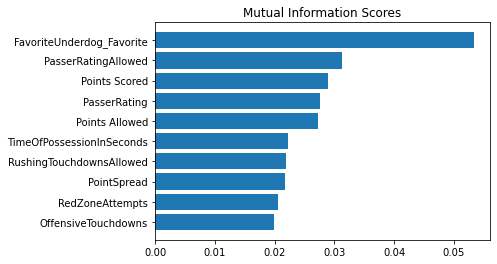

In [15]:
plot_mi_scores(mi_scores[:10])

In [16]:
baseline_score = score_dataset(X_train_preprocessed, y_train)
print("Baseline score: {}".format(baseline_score))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2328, number of negative: 2328
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6092
[LightGBM] [Info] Number of data points in the train set: 4656, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2328, number of negative: 2328
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6084
[LightGBM] [Info] Number of data points in the train set: 4656, numb

In [17]:
X_train_preprocessed = drop_uninformative(X_train_preprocessed, mi_scores)

# filtering for the same columns as training dataset
X_valid_preprocessed = X_valid_preprocessed[X_train_preprocessed.columns]
X_test_preprocessed = X_test_preprocessed[X_train_preprocessed.columns]

score_dataset(X_train_preprocessed, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2328, number of negative: 2328
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5106
[LightGBM] [Info] Number of data points in the train set: 4656, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2328, number of negative: 2328
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5104
[Ligh

0.6326460481099656

In [59]:
ml_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p)),
    ('scaler', MinMaxScaler((0, 1)))])
    


preprocessor_ml = ColumnTransformer(
    transformers=[
        ('ml', ml_transformer, list(X_train_preprocessed.columns))])


pipe_ml = Pipeline(steps=[('preprocessor', preprocessor_ml),])
X_train_preprocessed_log_minmax = pipe_ml.fit_transform(X_train_preprocessed)
X_valid_preprocessed_log_minmax = pipe_ml.transform(X_valid_preprocessed)
X_test_preprocessed_log_minmax = pipe_ml.transform(X_test_preprocessed)


X_train_preprocessed_log_minmax = pd.DataFrame(X_train_preprocessed_log_minmax, 
                                   columns=X_train_preprocessed.columns, 
                                     index=X_train_preprocessed.index)
X_valid_preprocessed_log_minmax = pd.DataFrame(X_valid_preprocessed_log_minmax, 
                                  columns=X_valid_preprocessed.columns, 
                                 index=X_valid_preprocessed.index)
X_test_preprocessed_log_minmax = pd.DataFrame(X_test_preprocessed_log_minmax, 
                                  columns=X_test_preprocessed.columns, 
                                 index=X_test_preprocessed.index)

X_train_preprocessed_log_minmax = X_train_preprocessed_log_minmax.dropna(axis=1)
X_valid_preprocessed_log_minmax = X_valid_preprocessed_log_minmax.dropna(axis=1)
X_test_preprocessed_log_minmax = X_test_preprocessed_log_minmax.dropna(axis=1)


## Test Models with Default Params

In [19]:
n_jobs = 3
nthread = 3
dtree = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(random_state=42, n_jobs=n_jobs)
adaBoost = AdaBoostClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42, n_jobs=n_jobs)
xgb = xgboost.XGBClassifier(random_state=42, nthread=nthread)
sv = svm.SVC(random_state=42)
logit = LogisticRegression(random_state=42)
knc = KNeighborsClassifier(n_jobs=n_jobs)

In [20]:
def evaluate_model(model, x_train, y_train, x_test, y_test, cv, model_name='model_dummy'):
    model = model.fit(x_train, y_train)
    
    # evaluate model using standard metrics
    cv_model = cross_validate(model, x_train, y_train, scoring=["recall_weighted", "precision_weighted", "roc_auc", "accuracy", "f1_weighted"], cv=cv, n_jobs=n_jobs)
    df = pd.DataFrame(cv_model)
    df = df.rename(columns={'test_recall_weighted': 'Recall', 'test_precision_weighted': 'Precision', 'test_roc_auc': 'AUC', 'test_accuracy': 'Accuracy', 'test_f1_weighted': 'F1'})

    # prediction scores
    pred = model.predict(x_test)
    test_recall_score = recall_score(y_test, pred, average='weighted')
    test_precision_score =  precision_score(y_test, pred, average='weighted')
    test_auc_score =  roc_auc_score(y_test, pred)
    test_accuracy_score = accuracy_score(y_test, pred)
    test_f1_score = f1_score(y_test, pred)

    df_cv = pd.DataFrame(df.mean(), columns=['{}_CV'.format(model_name)])
    df_cv.at['Recall', '{}_val'.format(model_name)] = test_recall_score
    df_cv.at['Precision', '{}_val'.format(model_name)] = test_precision_score
    df_cv.at['AUC', '{}_val'.format(model_name)] = test_auc_score
    df_cv.at['Accuracy', '{}_val'.format(model_name)] = test_accuracy_score
    df_cv.at['F1', '{}_val'.format(model_name)] = test_f1_score
    
    # plot the heatmap for crosstab matrix
    print('Completed {}'.format(model_name))
    df_crosstab = pd.DataFrame({'y_val': y_test, 'y_predicted': pred})

    plt.figure(figsize=(15,5))
    plt.title(model_name)
    ax = sns.heatmap(pd.crosstab(df_crosstab.y_val, df_crosstab.y_predicted).T, 
                square=True, annot=True, fmt='.2f')

    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0);
    
    return df_cv

### Validation Performance

Completed DT
Completed RF
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2910, number of negative: 2910
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5132
[LightGBM] [Info] Number of data points in the train set: 5820, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Completed lgbm


/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/cudf/utils/gpu_utils.py:165: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Completed xgb
Completed adaB


/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed knc
Completed svm


/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed Logit


,DT_CV,DT_val,RF_CV,RF_val,lgbm_CV,lgbm_val,xgb_CV,xgb_val,adaB_CV,adaB_val,knc_CV,knc_val,svm_CV,svm_val,Logit_CV,Logit_val
fit_time,0.155409,nan,0.503166,nan,0.210663,nan,1.276224,nan,0.595018,nan,0.003190,nan,1.181422,nan,0.091472,nan
score_time,0.006525,nan,0.116365,nan,0.011548,nan,0.009464,nan,0.027450,nan,0.355993,nan,0.558540,nan,0.009010,nan
Recall,0.567010,0.583791,0.620790,0.631868,0.635739,0.656593,0.612371,0.615385,0.647251,0.674451,0.611340,0.598901,0.661684,0.689560,0.661168,0.690934
Precision,0.567083,0.583842,0.620855,0.631968,0.635931,0.656598,0.612391,0.615976,0.647342,0.674557,0.611426,0.599490,0.661765,0.689612,0.661251,0.691051
AUC,0.567010,0.583791,0.667687,0.631868,0.671218,0.656593,0.647475,0.615385,0.666894,0.674451,0.642774,0.598901,0.683196,0.689560,0.679771,0.690934
Accuracy,0.567010,0.583791,0.620790,0.631868,0.635739,0.656593,0.612371,0.615385,0.647251,0.674451,0.611340,0.598901,0.661684,0.689560,0.661168,0.690934
F1,0.566885,0.588874,0.620743,0.636856,0.635598,0.657534,0.612352,0.628647,0.647201,0.678426,0.611269,0.613757,0.661644,0.692098,0.661125,0.694708


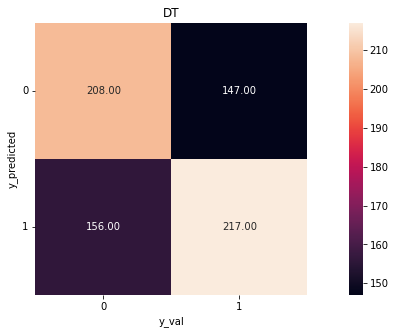

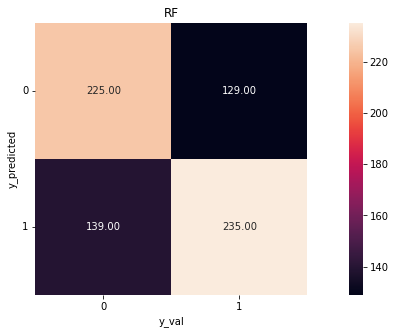

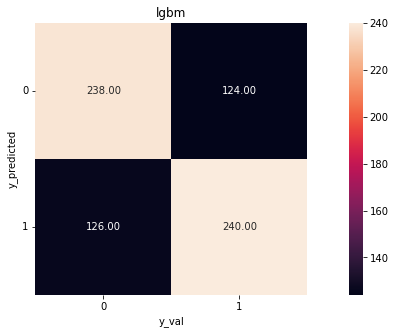

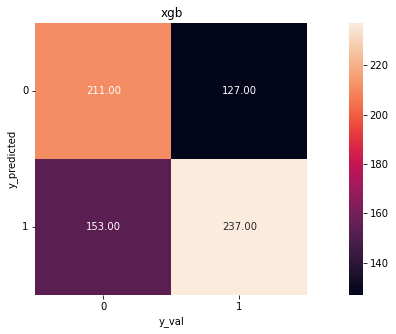

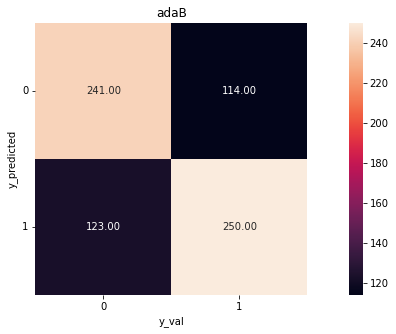

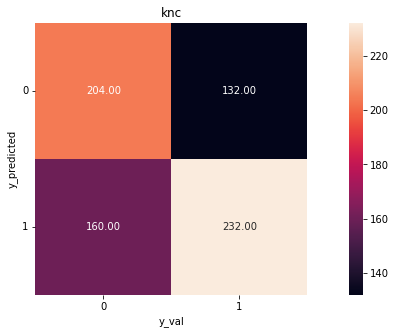

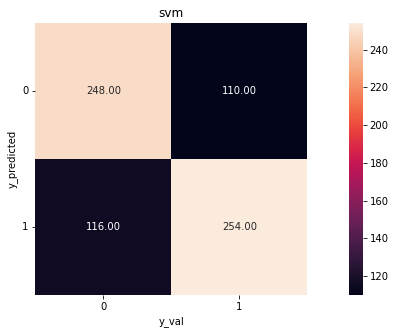

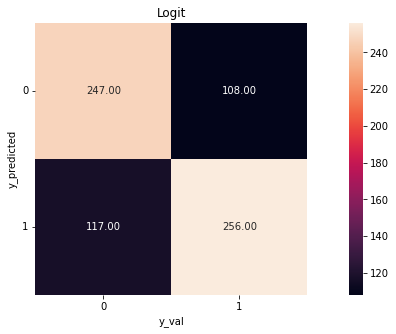

In [21]:
# Median rolling (na go through pipeline)
df_cv_dt = evaluate_model(dtree, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='DT'); #DecisionTree 10m
df_cv_rf= evaluate_model(forest, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='RF'); #RandomForest
df_cv_lgbm = evaluate_model(lgbm, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='lgbm');
df_cv_xgb = evaluate_model(xgb, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='xgb'); #xgBoost
df_cv_adaB = evaluate_model(adaBoost, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='adaB'); #adaBoost
df_cv_knc = evaluate_model(knc, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='knc');
df_cv_svm = evaluate_model(sv, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='svm');
df_cv_logit = evaluate_model(logit, X_train_preprocessed_log_minmax, y_train, X_valid_preprocessed_log_minmax, y_valid, 5, model_name='Logit');

# Printing out Cluster 9 companies
heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

pd.concat([df_cv_dt, df_cv_rf, df_cv_lgbm, df_cv_xgb, 
           df_cv_adaB, df_cv_knc, df_cv_svm, df_cv_logit], 
          axis=1).style.background_gradient(cmap='coolwarm', axis=1).set_table_styles(dfstyle)

Models of interest
- SVM
- Logistic Regression

Scoring Functions
- F1 for training
- Accuracy for validation

# Hyperparameter optimization

### Logistic Regression (45m CPU)

In [46]:
# Choose the type of classifier. 
logit_tuned = LogisticRegression(random_state=42)

# Grid of parameters to choose from
parameters = {
    "penalty": ['l1', 'l2'], # elastinet and none not used
    'dual': [False], # preferred
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    "C": [0.1, 1, 10, 100],
    'max_iter': [1000], # increased tenfold over default
    'solver': ['liblinear'], # For small datasets, liblinear is a good choice
    # "l1_ratio": [None], # l1 minimized
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
logit_grid_obj = GridSearchCV(logit_tuned, parameters, scoring=scorer, cv=5, verbose = 3)
logit_grid_obj = logit_grid_obj.fit(X_train_preprocessed_log_minmax, y_train)

# Set the clf to the best combination of parameters
logit_tuned = logit_grid_obj.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-06;, score=0.647 total time=   0.1s
[CV 2/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-06;, score=0.683 total time=   0.1s
[CV 3/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-06;, score=0.651 total time=   0.1s
[CV 4/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-06;, score=0.660 total time=   0.1s
[CV 5/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-06;, score=0.664 total time=   0.1s
[CV 1/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-05;, score=0.647 total time=   0.1s
[CV 2/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-05;, score=0.683 total time=   0.1s
[CV 3/5] END C=0.1, dual=False, max_iter=1000, penalty=l1, solver=liblinear, tol=1e-05;, score=0.6

In [29]:
logit_tuned = LogisticRegression(**{'C': 1,
 'dual': False,
 'max_iter': 1000,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.0001})

In [48]:
logit_grid_obj.best_params_

{'C': 1,
 'dual': False,
 'max_iter': 1000,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.0001}

Completed logit-hpo


,logit-hpo_CV,logit-hpo_val
fit_time,0.599476,nan
score_time,0.006676,nan
Recall,0.661512,0.667582
Precision,0.661580,0.667628
AUC,0.682871,0.667582
Accuracy,0.661512,0.667582
F1,0.661478,0.664820


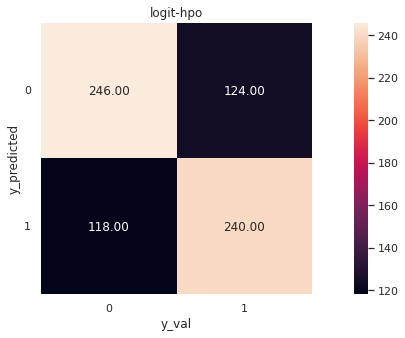

In [60]:
df_cv_logit_hpo_dropfa = evaluate_model(logit_tuned, X_train_preprocessed_log_minmax, y_train, X_test_preprocessed_log_minmax, y_test, 5, model_name='logit-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_logit_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

**Logistic Regression Notes**

Although the logistic regression can obtain better performance to the nonlinear SVM. Since it is linear, it is much preferred to SVM.

### SVM (6m CPU)

In [77]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
              'kernel': ['rbf']}  

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)
  
# Run the grid search
svm_grid_obj = GridSearchCV(sv, param_grid, scoring=scorer, cv=5, verbose = 3)
svm_grid_obj = svm_grid_obj.fit(X_train_preprocessed_log_minmax, y_train)

# Set the clf to the best combination of parameters
svm_tuned = svm_grid_obj.best_estimator_

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.647 total time=   1.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   1.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.639 total time=   1.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.659 total time=   1.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.656 total time=   1.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.646 total time=   1.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.683 total time=   1.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.651 total time=   1.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.660 total time=   1.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=   1.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.648 total time=   1.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [78]:
svm_tuned

SVC(C=0.1, gamma=1e-06, random_state=42)

Completed svm-hpo


,svm-hpo_CV,svm-hpo_val
fit_time,1.295463,nan
score_time,0.757290,nan
Recall,0.647938,0.655220
Precision,0.649252,0.656668
AUC,0.686788,0.655220
Accuracy,0.647938,0.655220
F1,0.647110,0.671035


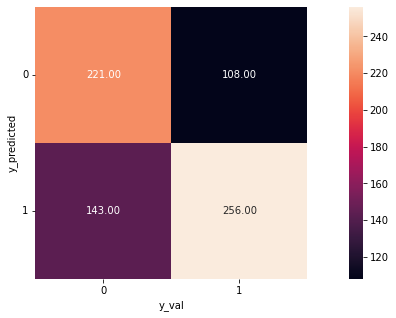

In [79]:
df_cv_svm_hpo = evaluate_model(svm_tuned, X_train_preprocessed_log_minmax, y_train, X_test_preprocessed_log_minmax, y_test, 5, model_name='svm-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_svm_hpo.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

Completed svm-hpo-dropfa


,svm-hpo-dropfa_CV,svm-hpo-dropfa_val
fit_time,1.146570,nan
score_time,0.671774,nan
Recall,0.648282,0.657967
Precision,0.649333,0.659276
AUC,0.687261,0.657967
Accuracy,0.648282,0.657967
F1,0.647611,0.672799


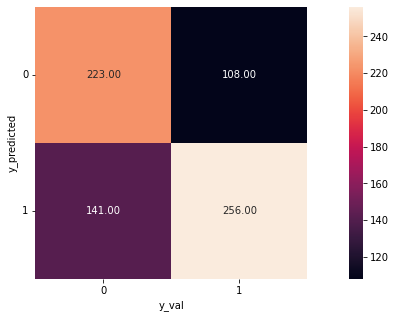

In [80]:
df_cv_svm_hpo_dropfa = evaluate_model(svm_tuned, X_train_preprocessed_log_minmax.drop(columns=df_fa_train_scaled.columns), y_train, X_test_preprocessed_log_minmax.drop(columns=df_fa_test_scaled.columns), y_test, 5, model_name='svm-hpo-dropfa');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_svm_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

**SVM HPO Notes**

SVM is very flexible, getting good results regardless of tuning and can obtain increased accuracy and f1 score with the FA columns removed. This algorithim though does take the longest to train and does not produce feature importance for RBF kernels. Although, it is overall not as performant as logistic regression, it does perform better on True Positives.

**XGBoost HPO Notes**
The model with the highest f1 score skewed dramatically towards prediciting wins. This is not ideal since prediciting a win is equally as important as prediciting a loss. That said, this model may prove useful when staked with the logistic regression model. Also, this model improves when the FA features are dropped.

## Ensembling (SVM + LR)

/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only

Completed sclf


,sclf_CV,sclf_val
fit_time,5.785945,nan
score_time,0.755249,nan
Recall,0.660825,0.668956
Precision,0.660913,0.669019
AUC,0.663178,0.668956
Accuracy,0.660825,0.668956
F1,0.660779,0.665742


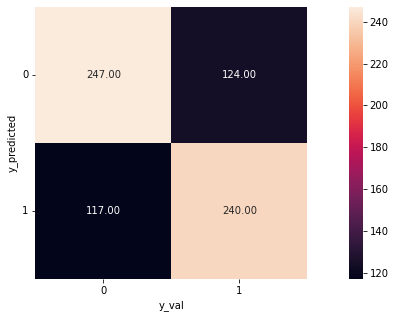

In [90]:
# logit_tuned = logit_tuned.fit(X_train_preprocessed_log_minmax, y_train) # retrain on dataset with all columns
sclf = StackingClassifier(estimators=[('svm', svm_tuned), ('logit', logit_tuned)])

df_cv_sclf = evaluate_model(sclf, X_train_preprocessed_log_minmax.drop(columns=df_fa_train_scaled.columns), y_train, X_test_preprocessed_log_minmax.drop(columns=df_fa_test_scaled.columns), y_test, 5, model_name='sclf');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_sclf.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

This ensemble model performs to the same efficacy as logistic regression alone.

## Tree Methods

### ADABoost (5m CPU)

In [98]:
# Grid of parameters to choose from
parameters = {
    "n_estimators": [25, 50, 100, 250],
    "algorithm":['SAMME', 'SAMME.R'],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
}
# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
adb_grid_obj = GridSearchCV(adaBoost, parameters, scoring=scorer, cv=5, verbose = 3)
adb_grid_obj = adb_grid_obj.fit(X_train_preprocessed_log_minmax, y_train)

# Set the clf to the best combination of parameters
adb_tuned = adb_grid_obj.best_estimator_

# Fit the best algorithm to the data.
adb_tuned.fit(X_train_preprocessed_log_minmax, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=25;, score=0.646 total time=   0.4s
[CV 2/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=25;, score=0.683 total time=   0.4s
[CV 3/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=25;, score=0.651 total time=   0.4s
[CV 4/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=25;, score=0.660 total time=   0.5s
[CV 5/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=25;, score=0.664 total time=   0.5s
[CV 1/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=50;, score=0.646 total time=   0.8s
[CV 2/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=50;, score=0.683 total time=   0.8s
[CV 3/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=50;, score=0.651 total time=   0.8s
[CV 4/5] END algorithm=SAMME, learning_rate=0.01, n_estimators=50;, score=0.660 total time=   0.8s
[CV 5/5] END algorithm=SAMME, learning_rate=0.0

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.2, n_estimators=100,
                   random_state=42)

Completed adb-hpo


,adb-hpo_CV,adb-hpo_val
fit_time,1.652308,nan
score_time,0.033557,nan
Recall,0.662027,0.663462
Precision,0.662099,0.663522
AUC,0.683919,0.663462
Accuracy,0.662027,0.663462
F1,0.661992,0.660194


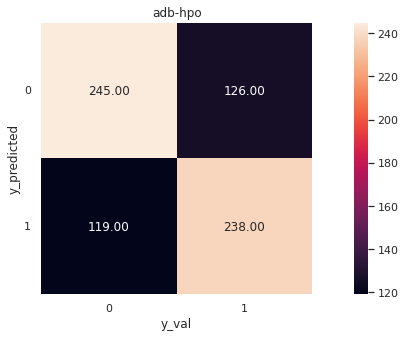

In [99]:
df_cv_adb_hpo = evaluate_model(adb_tuned, X_train_preprocessed_log_minmax, y_train, X_test_preprocessed_log_minmax, y_test, 5, model_name='adb-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_adb_hpo.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

Completed adb-hpo-dropfa


,adb-hpo-dropfa_CV,adb-hpo-dropfa_val
fit_time,1.294342,nan
score_time,0.028647,nan
Recall,0.661856,0.663462
Precision,0.661933,0.663522
AUC,0.684429,0.663462
Accuracy,0.661856,0.663462
F1,0.661817,0.660194


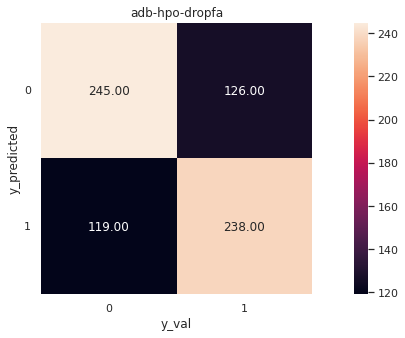

In [100]:
df_cv_adb_hpo_dropfa = evaluate_model(adb_tuned, X_train_preprocessed_log_minmax.drop(columns=df_fa_train_scaled.columns), y_train, X_test_preprocessed_log_minmax.drop(columns=df_fa_test_scaled.columns), y_test, 5, model_name='adb-hpo-dropfa');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_adb_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

Adaboost even with HPO is unable to outperform logistic regression, performing worse on both classes.

### LGBM (20m CPU)

In [ ]:
lgbm_tuned = lgbm

# Grid of parameters to choose from
parameters = {
    'learning_rate': [0.01, 0.1, 0.4],
    'n_estimators': [8, 16, 32, 64, 128],
    'num_leaves': [8, 16, 32, 64],
    'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'], 
    'max_bin':[64, 128, 256, 512],
    'colsample_bytree' : [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample' : [0.6, 0.7, 0.8],
    'reg_alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
    'reg_lambda' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
lgbm_grid_obj = GridSearchCV(lgbm_tuned, parameters, scoring=scorer, cv=5, verbose = 3)
lgbm_grid_obj = lgbm_grid_obj.fit(X_train_preprocessed_log_minmax, y_train)

# Set the clf to the best combination of parameters
lgbm_tuned = lgbm_grid_obj.best_estimator_

# Fit the best algorithm to the data.
lgbm_tuned.fit(X_train_preprocessed_log_minmax, y_train)

Completed lgbm-hpo


,lgbm-hpo_CV,lgbm-hpo_val
fit_time,0.064459,nan
score_time,0.011187,nan
Recall,0.660309,0.660714
Precision,0.660571,0.660725
AUC,0.684695,0.660714
Accuracy,0.660309,0.660714
F1,0.660154,0.659310


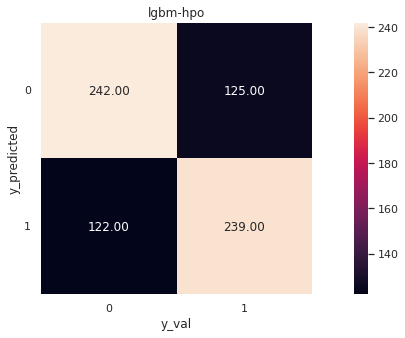

In [103]:
df_cv_lgbm_hpo = evaluate_model(lgbm_tuned, X_train_preprocessed_log_minmax, y_train, X_test_preprocessed_log_minmax, y_test, 5, model_name='lgbm-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_lgbm_hpo.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

Completed lgbm-hpo-dropfa


,lgbm-hpo-dropfa_CV,lgbm-hpo-dropfa_val
fit_time,0.051714,nan
score_time,0.008991,nan
Recall,0.658247,0.670330
Precision,0.658380,0.670330
AUC,0.686348,0.670330
Accuracy,0.658247,0.670330
F1,0.658165,0.670330


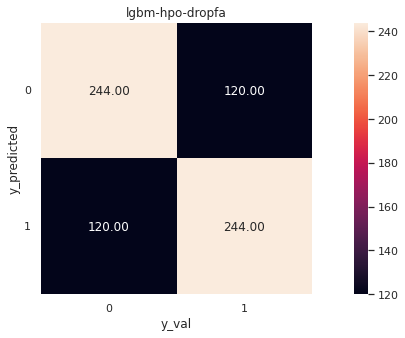

In [104]:
df_cv_lgbm_hpo_dropfa = evaluate_model(lgbm_tuned, X_train_preprocessed_log_minmax.drop(columns=df_fa_train_scaled.columns), y_train, X_test_preprocessed_log_minmax.drop(columns=df_fa_test_scaled.columns), y_test, 5, model_name='lgbm-hpo-dropfa');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_lgbm_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

The LGBM model trained without the FA features performs better overall. It is also perfectly generalized between positive and negative predictions.

## Ensembling (SVM + LR + LGBM)

/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/root/anaconda3/envs/sprtsiq/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only

Completed sclf


,sclf_CV,sclf_val
fit_time,7.628942,nan
score_time,0.997565,nan
Recall,0.661684,0.668956
Precision,0.661806,0.669019
AUC,0.686321,0.668956
Accuracy,0.661684,0.668956
F1,0.661617,0.665742


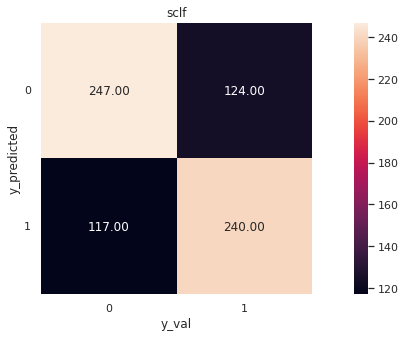

In [106]:
# logit_tuned = logit_tuned.fit(X_train_preprocessed_log_minmax, y_train) # retrain on dataset with all columns
sclf = StackingClassifier(estimators=[('svm', svm_tuned), ('logit', logit_tuned), ('lgbm', lgbm_tuned)])

df_cv_sclf = evaluate_model(sclf, X_train_preprocessed_log_minmax.drop(columns=df_fa_train_scaled.columns), y_train, X_test_preprocessed_log_minmax.drop(columns=df_fa_test_scaled.columns), y_test, 5, model_name='sclf');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_sclf.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

This ensemble model performs to the same efficacy as logistic regression alone.

## Feature Elimination

Text(0.5, 1.0, 'Feature Importance')

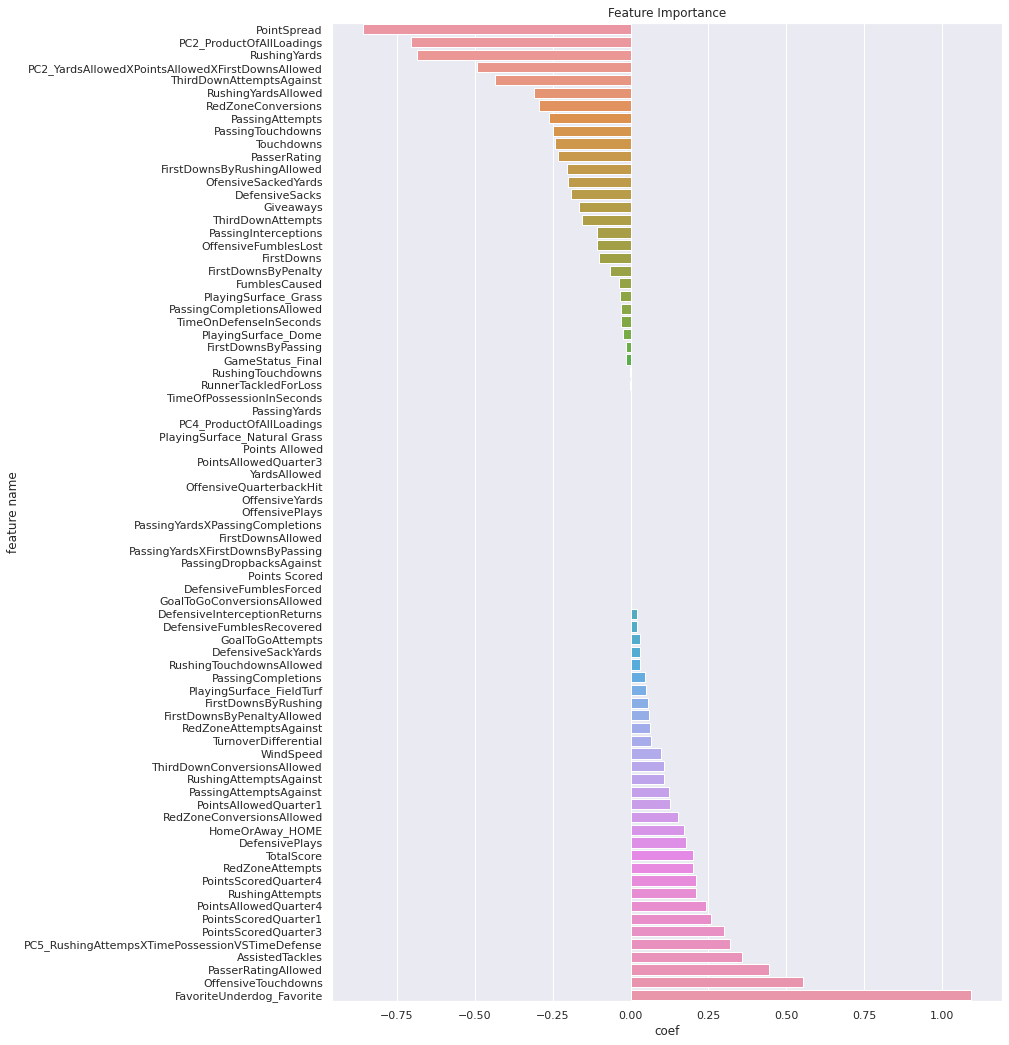

In [61]:
feature_importance_df = pd.DataFrame({
    'coef': logit_tuned.coef_.flatten(), 
    'feature name': X_train_preprocessed_log_minmax.columns
})
sns.set(rc={'figure.figsize':(12,18)})
sns.barplot(data=feature_importance_df.sort_values(by='coef'), x='coef', y='feature name')
plt.title('Feature Importance')

There are many features with miniscule coefficients, I will use recursive feature elimination to extract the most valuable features to the logistic regression model.

In [33]:
from sklearn.feature_selection import RFE

Text(0.5, 1.0, 'Reduced Feature Importance')

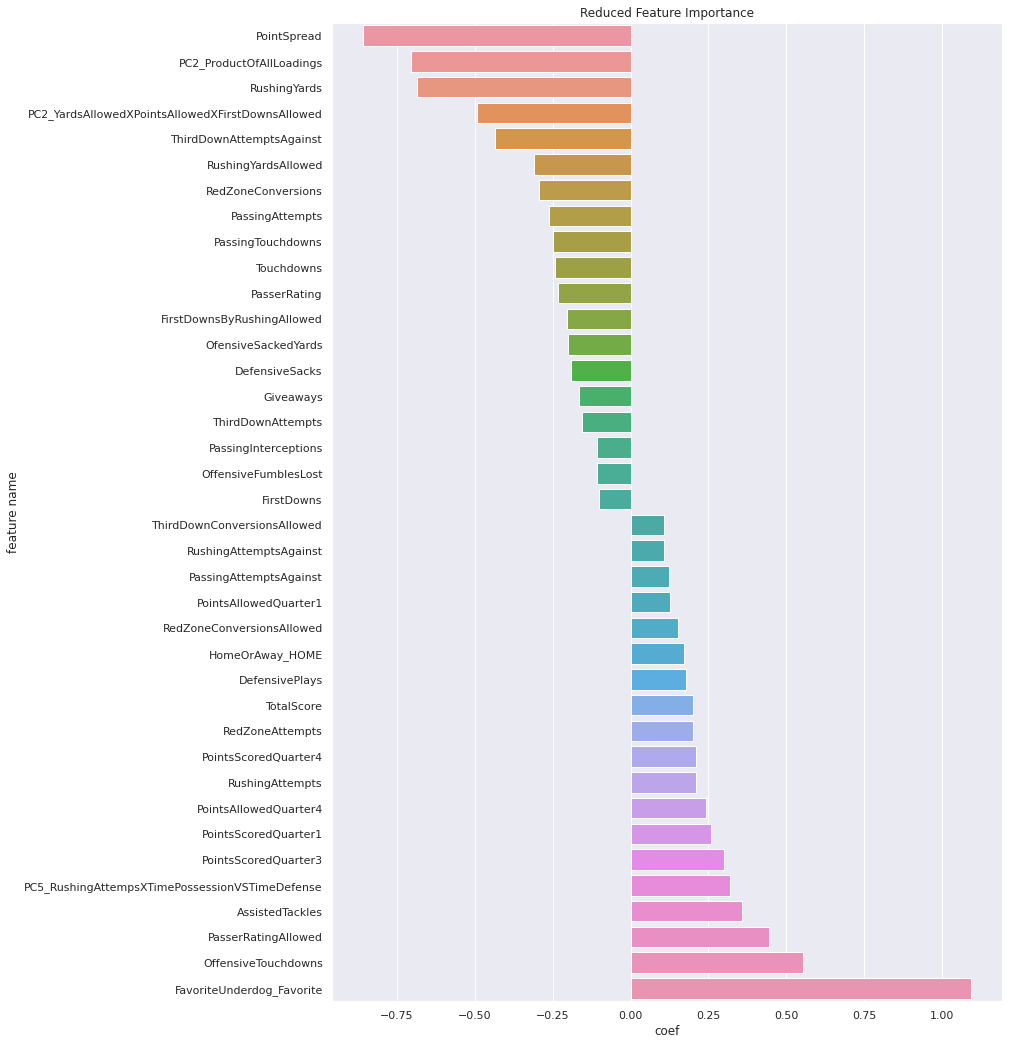

In [62]:
selector = RFE(logit_tuned)
selector = selector.fit(X_train_preprocessed_log_minmax, y_train)
feature_importance_df = pd.DataFrame({
    'coef': logit_tuned.coef_.flatten(), 
    'feature name': X_train_preprocessed_log_minmax.columns,
    'keep': selector.support_
})

reduced_feature_importance_df = feature_importance_df[feature_importance_df['keep']]

sns.set(rc={'figure.figsize':(12,18)})
sns.barplot(data=reduced_feature_importance_df.sort_values(by='coef'), x='coef', y='feature name')
plt.title('Reduced Feature Importance')

In [63]:
X_train_preprocessed_log_minmax_reduced = X_train_preprocessed_log_minmax[reduced_feature_importance_df['feature name'].values]
X_test_preprocessed_log_minmax_reduced = X_test_preprocessed_log_minmax[reduced_feature_importance_df['feature name'].values]

Completed logit-hpo


,logit-hpo_CV,logit-hpo_val
fit_time,0.303381,nan
score_time,0.007121,nan
Recall,0.663058,0.667582
Precision,0.663133,0.667628
AUC,0.688545,0.667582
Accuracy,0.663058,0.667582
F1,0.663022,0.664820


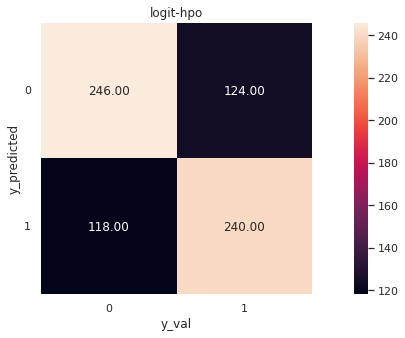

In [64]:
df_cv_logit_hpo_dropfa = evaluate_model(logit_tuned, X_train_preprocessed_log_minmax_reduced, y_train, X_test_preprocessed_log_minmax_reduced, y_test, 5, model_name='logit-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_logit_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

Accuracy is maintained while using only 50% of the features. I run this test again to see if I can eliminate the features further.

Text(0.5, 1.0, 'Super Reduced Feature Importance')

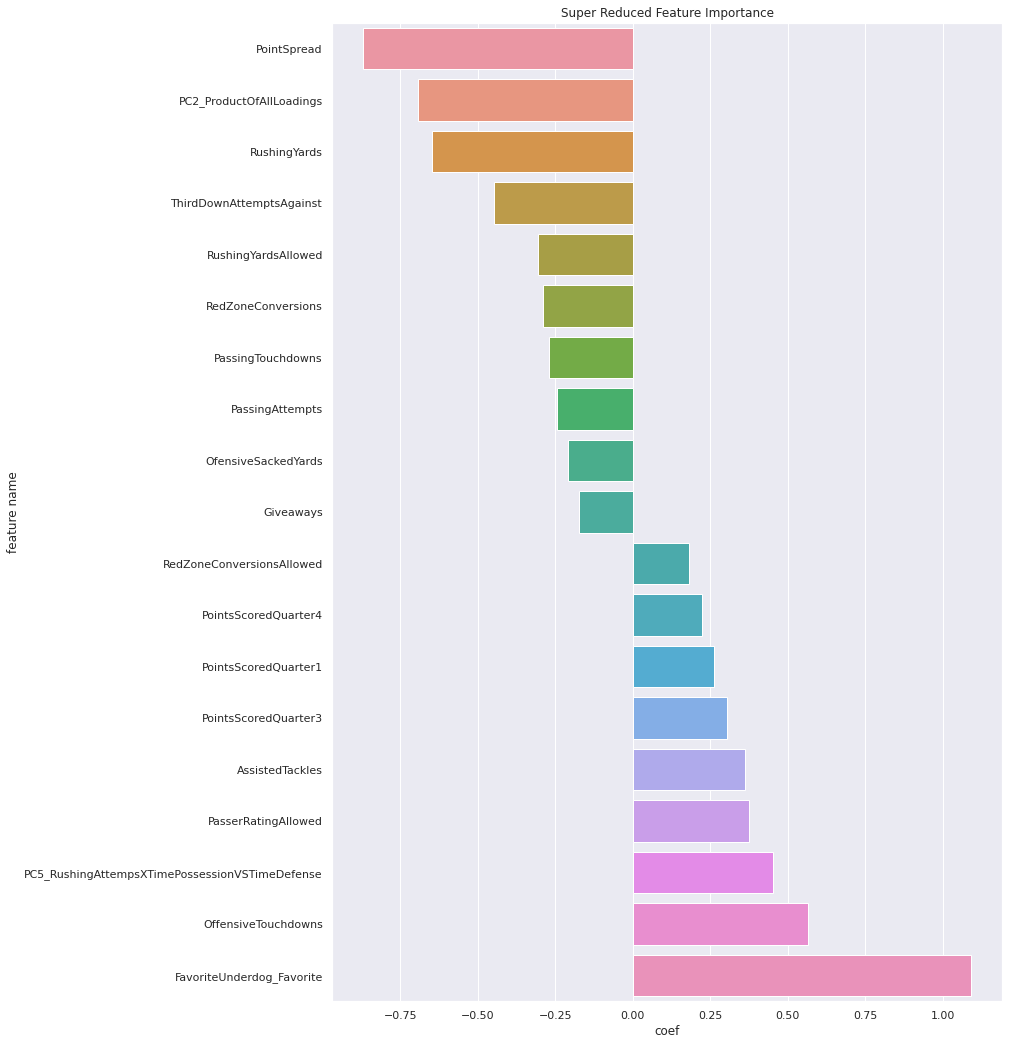

In [67]:
selector = RFE(logit_tuned)
selector = selector.fit(X_train_preprocessed_log_minmax_reduced, y_train)
feature_importance_df = pd.DataFrame({
    'coef': logit_tuned.coef_.flatten(), 
    'feature name': X_train_preprocessed_log_minmax_reduced.columns,
    'keep': selector.support_
})

super_reduced_feature_importance_df = feature_importance_df[feature_importance_df['keep']]

sns.set(rc={'figure.figsize':(12,18)})
sns.barplot(data=super_reduced_feature_importance_df.sort_values(by='coef'), x='coef', y='feature name')
plt.title('Super Reduced Feature Importance')

In [74]:
X_train_preprocessed_log_minmax_super_reduced = X_train_preprocessed_log_minmax_reduced[super_reduced_feature_importance_df['feature name'].values]
X_test_preprocessed_log_minmax_super_reduced = X_test_preprocessed_log_minmax_reduced[super_reduced_feature_importance_df['feature name'].values]

Completed logit-hpo


,logit-hpo_CV,logit-hpo_val
fit_time,0.075149,nan
score_time,0.007025,nan
Recall,0.662027,0.667582
Precision,0.662118,0.667628
AUC,0.691828,0.667582
Accuracy,0.662027,0.667582
F1,0.661982,0.664820


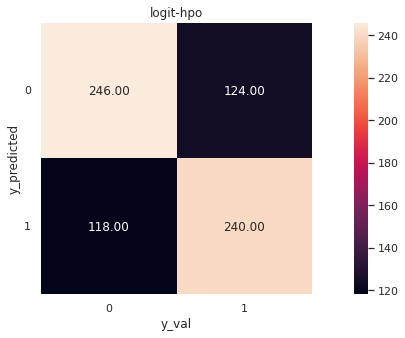

In [75]:
df_cv_logit_hpo_dropfa = evaluate_model(logit_tuned, X_train_preprocessed_log_minmax_super_reduced, y_train, X_test_preprocessed_log_minmax_super_reduced, y_test, 5, model_name='logit-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_logit_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

Accuracy is maintained while using only 25% of the original features. I run this test again to see if I can eliminate the features further.

Text(0.5, 1.0, 'Super Reduced Feature Importance')

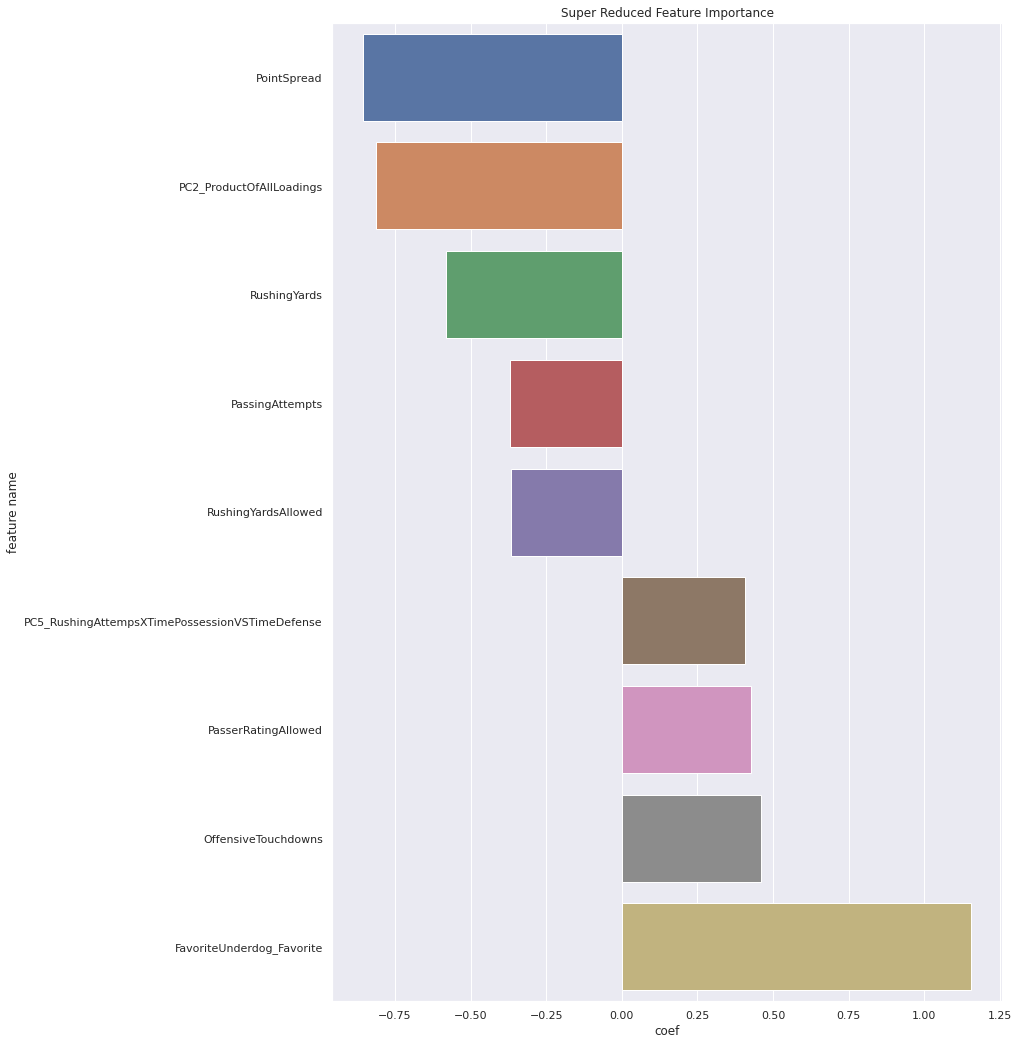

In [76]:
selector = RFE(logit_tuned)
selector = selector.fit(X_train_preprocessed_log_minmax_super_reduced, y_train)
feature_importance_df = pd.DataFrame({
    'coef': logit_tuned.coef_.flatten(), 
    'feature name': X_train_preprocessed_log_minmax_super_reduced.columns,
    'keep': selector.support_
})

ultra_reduced_feature_importance_df = feature_importance_df[feature_importance_df['keep']]

sns.set(rc={'figure.figsize':(12,18)})
sns.barplot(data=ultra_reduced_feature_importance_df.sort_values(by='coef'), x='coef', y='feature name')
plt.title('Super Reduced Feature Importance')

In [77]:
X_train_preprocessed_log_minmax_ultra_reduced = X_train_preprocessed_log_minmax_super_reduced[ultra_reduced_feature_importance_df['feature name'].values]
X_test_preprocessed_log_minmax_ultra_reduced = X_test_preprocessed_log_minmax_super_reduced[ultra_reduced_feature_importance_df['feature name'].values]

Completed logit-hpo


,logit-hpo_CV,logit-hpo_val
fit_time,0.041055,nan
score_time,0.007033,nan
Recall,0.662199,0.664835
Precision,0.662267,0.664880
AUC,0.690671,0.664835
Accuracy,0.662199,0.664835
F1,0.662165,0.662050


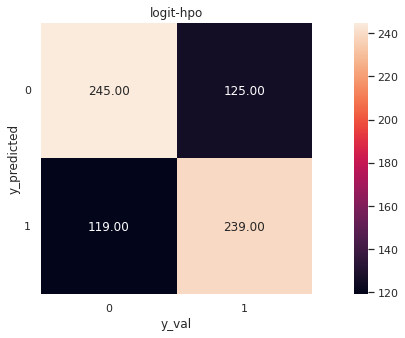

In [78]:
df_cv_logit_hpo_dropfa = evaluate_model(logit_tuned, X_train_preprocessed_log_minmax_ultra_reduced, y_train, X_test_preprocessed_log_minmax_ultra_reduced, y_test, 5, model_name='logit-hpo');

heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]

dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]

df_cv_logit_hpo_dropfa.style.background_gradient(cmap='coolwarm').set_table_styles(dfstyle)

This caused a tiny drop in accuracy, I will compromise by keeping features with coeficients that have an absolute value greater than 0.25

In [84]:
print('Final Feature List')
for feature in feature_importance_df[np.abs(feature_importance_df['coef']) > 0.25]['feature name'].values:
    print('\t', feature)

Final Feature List
	 RushingYardsAllowed
	 AssistedTackles
	 PasserRatingAllowed
	 PassingAttempts
	 PointsScoredQuarter1
	 OffensiveTouchdowns
	 RedZoneConversionsAllowed
	 RushingYards
	 PointsScoredQuarter3
	 Giveaways
	 PassingTouchdowns
	 ThirdDownAttemptsAgainst
	 PointSpread
	 PC2_ProductOfAllLoadings
	 PC5_RushingAttempsXTimePossessionVSTimeDefense
	 FavoriteUnderdog_Favorite
